In [1]:
import pandas
import datetime
import numpy
from scipy import signal, ndimage
from davitpy.models import *
from davitpy import utils
from davitpy.pydarn.plotting import *
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.colors import Normalize
from matplotlib import ticker
import seaborn as sns
import matplotlib.cm as cm
%matplotlib inline

In [2]:
selDT = datetime.datetime( 2012, 6, 18, 2, 45 )

In [3]:
inpTecFile = "../data/gps120618g.001.hdf5"
dataDF = pandas.read_hdf(inpTecFile, 'Data/Table Layout')
dataDF["date"] = pandas.to_datetime(dataDF["year"]*10000000000 +\
                                    dataDF["month"]*100000000 + dataDF["day"]*1000000 +\
                                    dataDF["hour"]*10000 + dataDF["min"]*100 +\
                                    dataDF["sec"],format='%Y%m%d%H%M%S')
# Only take selected datetime
dataDF["selTimeDel"] = dataDF["date"] - selDT
dataDF = dataDF[ dataDF["selTimeDel"] == min(abs(dataDF["selTimeDel"])) ].reset_index(drop=True)
# Discard bad tec values
dataDF = dataDF[ dataDF["tec"] <= 50. ]
dataDF.head()

,year,month,day,hour,min,sec,ut1_unix,ut2_unix,recno,gdlat,glon,tec,dtec,date,selTimeDel
0,2012,6,18,2,47,30,1339987500,1339987800,68,-90,149,1.9,2.6,2012-06-18 02:47:30,00:02:30
1,2012,6,18,2,47,30,1339987500,1339987800,68,-90,152,1.9,2.6,2012-06-18 02:47:30,00:02:30
2,2012,6,18,2,47,30,1339987500,1339987800,68,-90,155,1.4,2.6,2012-06-18 02:47:30,00:02:30
3,2012,6,18,2,47,30,1339987500,1339987800,68,-90,157,1.1,2.6,2012-06-18 02:47:30,00:02:30
4,2012,6,18,2,47,30,1339987500,1339987800,68,-90,159,1.0,2.6,2012-06-18 02:47:30,00:02:30


In [4]:
# medDF = dataDF[ [ "gdlat", "glon", "tec" ] ]
medDF = dataDF.pivot( index="gdlat", columns="glon", values="tec" )
test3 = ndimage.filters.median_filter( medDF.as_matrix(), size=(1,2) )

In [5]:
medDF.head()

glon,-180.0,-179.0,-178.0,-177.0,-176.0,-175.0,-174.0,-173.0,-172.0,-171.0,...,170.0,171.0,172.0,173.0,174.0,175.0,176.0,177.0,178.0,179.0
gdlat,,,,,,,,,,,,,,,,,,,,,
-90,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-89,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.4,NaN,3.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-88,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-87,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.4,5.4,5.4,5.4,5.4,NaN,NaN,4.3,4.1,3.8
-86,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
medDF[ medDF.columns ] = test3
medDF.head()

glon,-180.0,-179.0,-178.0,-177.0,-176.0,-175.0,-174.0,-173.0,-172.0,-171.0,...,170.0,171.0,172.0,173.0,174.0,175.0,176.0,177.0,178.0,179.0
gdlat,,,,,,,,,,,,,,,,,,,,,
-90,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-89,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-88,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.9,3.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-87,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.4,5.4,5.4,5.4,5.4,5.4,NaN,NaN,4.3,4.1
-86,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
medDF = medDF.unstack().reset_index()
medDF.columns = [ "glon", "gdlat", "med_tec" ]
# medDF = pandas.merge( medDF, dataDF, on=[ "glon", "gdlat" ] )
medDF.head()

,glon,gdlat,med_tec
0,-180,-90,NaN
1,-180,-89,NaN
2,-180,-88,NaN
3,-180,-87,NaN
4,-180,-86,NaN


In [8]:
gLonArr = medDF["glon"].values
gdLatArr = medDF["gdlat"].values
mlon, mlat = utils.coord_conv( gLonArr, gdLatArr, \
                                 "geo", "mag", altitude=300., \
                                 date_time=selDT )
medDF["mlon"] = mlon
medDF["mlat"] = mlat
medDF["mlt"] = [ aacgm.mltFromYmdhms(selDT.year, \
                selDT.month,selDT.day, selDT.hour,\
                selDT.minute, selDT.second, x) for x in medDF["mlon"] ]
medDF["normMLT"] = [x-24 if x >= 12\
             else x for x in medDF['mlt']]
medDF.head()

,glon,gdlat,med_tec,mlon,mlat,mlt,normMLT
0,-180,-90,NaN,18.472788,-74.917784,23.131213,-0.868787
1,-180,-89,NaN,15.508806,-75.451646,22.933614,-1.066386
2,-180,-88,NaN,12.294946,-75.948940,22.719357,-1.280643
3,-180,-87,NaN,8.823391,-76.403395,22.487920,-1.512080
4,-180,-86,NaN,5.092981,-76.808426,22.239226,-1.760774


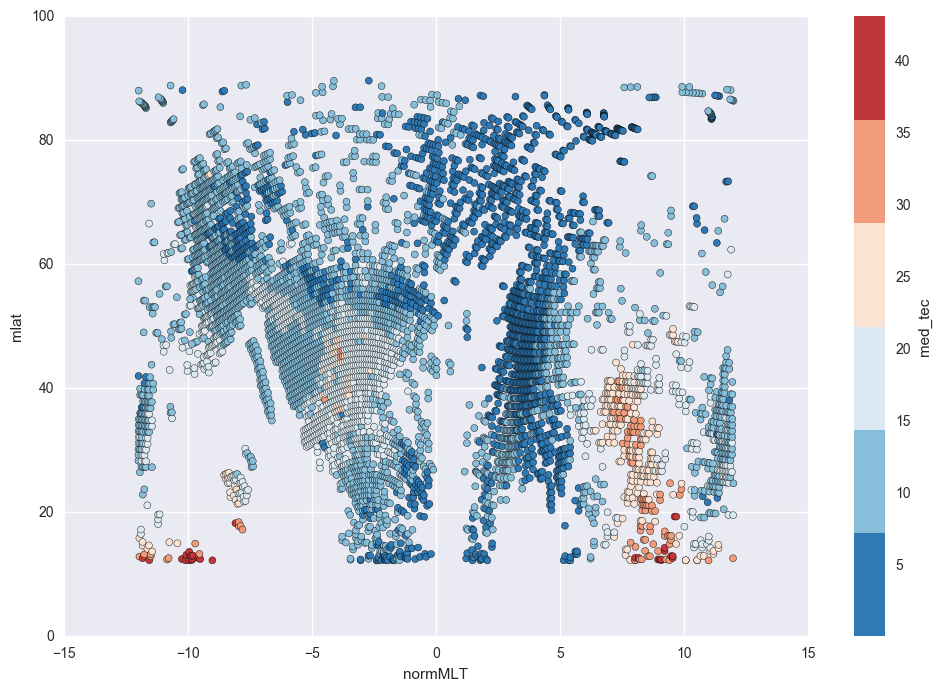

In [9]:
f = plt.figure(figsize=(12, 8))
ax = f.add_subplot(1,1,1)
seaMap = ListedColormap(sns.color_palette("RdBu_r"))
medDF[medDF["mlat"] > 0.].plot( kind='scatter',
              x='normMLT',
              y='mlat',
              c='med_tec',
              s=25, cmap=seaMap, ax=ax)#, marker="s"

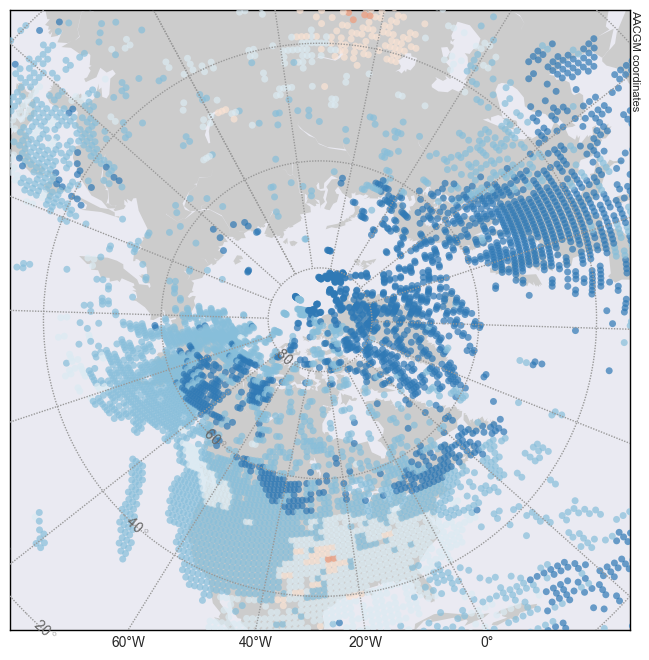

In [10]:
# Plot map
f = plt.figure(figsize=(12, 8))
ax = f.add_subplot(1,1,1)
m1 = utils.plotUtils.mapObj(boundinglat=30., gridLabels=True, coords='mag', ax=ax, datetime=selDT)
xVec, yVec = m1(list(medDF["mlon"]), list(medDF["mlat"]), coords="mag")
m1.scatter( xVec, yVec , c=medDF["med_tec"], s=25.,\
           cmap=seaMap, alpha=0.7, zorder=5., edgecolor='none' )
